# Neural style transfer

## Setup

### Importando e configurando os modulos

In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals

In [2]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf

TensorFlow 2.x selected.


In [0]:
import IPython.display as display

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12,12)
mpl.rcParams['axes.grid'] = False

import numpy as np
import time
import functools

Fazendo download das imagens e escolhendo a imagem do estilo e a do conteúdo

In [4]:
content_url = 'https://picsum.photos/id/884/512/512'
style_url = 'https://upload.wikimedia.org/wikipedia/commons/thumb/e/ea/Van_Gogh_-_Starry_Night_-_Google_Art_Project.jpg/1280px-Van_Gogh_-_Starry_Night_-_Google_Art_Project.jpg'

content_path = tf.keras.utils.get_file('content.jpg', content_url)
style_path = tf.keras.utils.get_file('style.jpg', style_url)

  32768/Unknown - 0s 1us/stepDownloading data from https://upload.wikimedia.org/wikipedia/commons/thumb/e/ea/Van_Gogh_-_Starry_Night_-_Google_Art_Project.jpg/1280px-Van_Gogh_-_Starry_Night_-_Google_Art_Project.jpg
614400/613563 [==============================] - 0s 0us/step


## Visualizando os inputs

Definindo uma função para carregar uma imagem e limitar as suas dimenções maxias a 512px

In [0]:
def load_img(path_to_img):
  max_dim = 512
  img = tf.io.read_file(path_to_img)
  img = tf.image.decode_image(img, channels=3)
  img = tf.image.convert_image_dtype(img, tf.float32)

  shape = tf.cast(tf.shape(img)[:-1], tf.float32)
  long_dim = max(shape)
  scale = max_dim / long_dim

  new_shape = tf.cast(shape * scale, tf.int32)

  img = tf.image.resize(img, new_shape)
  img = img[tf.newaxis, :]
  return img

Criando uma função simples pra exibir uma imagem:

In [0]:
def imshow(image, title=None):
  if len(image.shape) > 3:
    image = tf.squeeze(image, axis=0)

  plt.imshow(image)
  if title:
    plt.title(title)

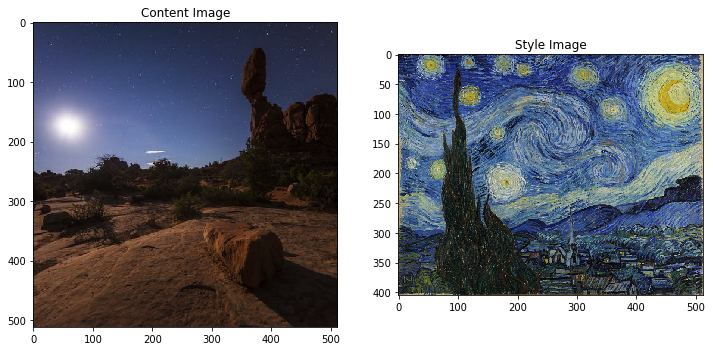

In [7]:
content_image = load_img(content_path)
style_image = load_img(style_path)

plt.subplot(1, 2, 1)
imshow(content_image, 'Content Image')

plt.subplot(1, 2, 2)
imshow(style_image, 'Style Image')

## Definindo a representção do conteúdo e do estilo

Usamos as camadas intermediárias do modelo para obter as representações de conteúdo e estilo da imagem. A partir da camada de entrada da rede, as primeiras ativações da camada representam recursos de baixo nível, como bordas e texturas. À medida que você percorre a rede, as poucas camadas finais representam recursos de nível superior - partes de objetos como rodas ou olhos. Nesse caso, estamos usando a arquitetura de rede VGG19, uma rede de classificação de imagem pré-treinada. Essas camadas intermediárias são necessárias para definir a representação do conteúdo e do estilo das imagens. Para uma imagem de entrada, tentamos combinar as representações de estilo e destino de conteúdo correspondentes nessas camadas intermediárias.

Baixando uma [VGG19](https://keras.io/applications/#vgg19) e testando na nossa imagem para certifircamos que tudo funciona corretamente.

In [8]:
x = tf.keras.applications.vgg19.preprocess_input(content_image*255)
x = tf.image.resize(x, (224, 224))
vgg = tf.keras.applications.VGG19(include_top=True, weights='imagenet')
prediction_probabilities = vgg(x)
prediction_probabilities.shape

574717952/574710816 [==============================] - 35s 0us/step


TensorShape([1, 1000])

In [9]:
predicted_top_5 = tf.keras.applications.vgg19.decode_predictions(prediction_probabilities.numpy())[0]
[(class_name, prob) for (number, class_name, prob) in predicted_top_5]

40960/35363 [==================================] - 0s 0us/step


[('megalith', 0.33201256),
 ('cliff_dwelling', 0.20706771),
 ('cliff', 0.14752243),
 ('wreck', 0.050594278),
 ('seashore', 0.049617253)]

Agora usanmos a **VGG19** sem o cabeçario de classificação, e listamos os nomes das camadas.

In [10]:
vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')

print()
for layer in vgg.layers:
  print(layer.name)

80142336/80134624 [==============================] - 7s 0us/step

input_2
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool


Escolhemos as camadas intermediarias da rede para representar o estilo e o conteudo da imagem:

In [0]:
# Content layer where will pull our feature maps
content_layers = ['block5_conv2'] 

# Style layer of interest
style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1', 
                'block4_conv1', 
                'block5_conv1']

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

#### Camadas intermediarias para estilo e conteúdo

Então, por que essas saídas intermediárias em nossa rede de classificação de imagens pré-treinada nos permite definir representações de estilo e conteúdo?

Em um nível alto, para que uma rede execute a classificação da imagem (para a qual essa rede foi treinada), ela deve entender a imagem. Isso requer a captura da imagem bruta como pixels de entrada e a construção de uma representação interna que converta os pixels brutos da imagem em um entendimento complexo dos recursos presentes na imagem.

Essa também é uma razão pela qual as redes neurais convolucionais são capazes de generalizar bem: elas são capazes de capturar as invariâncias e os recursos de definição dentro das classes (por exemplo, gatos x cães) que são agnósticos ao ruído de fundo e outros incômodos. Portanto, em algum lugar entre o local em que a imagem bruta é inserida no modelo e a etiqueta de classificação de saída, o modelo serve como um extrator de recursos complexo. Ao acessar camadas intermediárias do modelo, você pode descrever o conteúdo e o estilo das imagens de entrada.


## Construindo o modelo 

As redes 
As redes em `tf.keras.applications` foram projetadas para que você possa extrair facilmente os valores da camada intermediária usando a API funcional Keras.

Para definir um modelo usando a API funcional, especifique as entradas e saídas:

`model = Model(input, outputs)`

Esta função a seguir cria um modelo **VGG19** que retorna uma lista de saídas da camada intermediária:

In [0]:
def vgg_layers(layer_names):
  """ Creates a vgg model that returns a list of intermediate output values."""
  # Load our model. Load pretrained VGG, trained on imagenet data
  vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
  vgg.trainable = False
  
  outputs = [vgg.get_layer(name).output for name in layer_names]

  model = tf.keras.Model([vgg.input], outputs)
  return model

E para criar o modelo:

In [17]:
style_extractor = vgg_layers(style_layers)
style_outputs = style_extractor(style_image*255)

#Look at the statistics of each layer's output
for name, output in zip(style_layers, style_outputs):
  print(name)
  print("  shape: ", output.numpy().shape)
  print("  min: ", output.numpy().min())
  print("  max: ", output.numpy().max())
  print("  mean: ", output.numpy().mean())
  print()

block1_conv1
  shape:  (1, 405, 512, 64)
  min:  0.0
  max:  674.46716
  mean:  24.261509

block2_conv1
  shape:  (1, 202, 256, 128)
  min:  0.0
  max:  2908.5828
  mean:  150.42699

block3_conv1
  shape:  (1, 101, 128, 256)
  min:  0.0
  max:  7352.8003
  mean:  144.2811

block4_conv1
  shape:  (1, 50, 64, 512)
  min:  0.0
  max:  16498.193
  mean:  568.2346

block5_conv1
  shape:  (1, 25, 32, 512)
  min:  0.0
  max:  3951.4053
  mean:  48.530216



## Calculando o estilo

O conteúdo de uma imagem é representado pelos valores dos mapas de recursos intermediários.

Acontece que o estilo de uma imagem pode ser descrito pelos meios e correlações entre os diferentes mapas de recursos. Calcule uma matriz Gram que inclui essas informações, levando consigo o produto externo do vetor de recurso em cada local e calculando a média desse produto externo em todos os locais. Essa matriz Gram pode ser calculada para uma camada específica como:

$$G^l_{cd} = \frac{\sum_{ij} F^l_{ijc}(x)F^l_{ijd}(x)}{IJ}$$

Isso pode ser implementado de forma concisa usando a função `tf.linalg.einsum`:

In [0]:
def gram_matrix(input_tensor):
  result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
  input_shape = tf.shape(input_tensor)
  num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
  return result/(num_locations)

## Extraindo o estilo e o conteudo
Construindo um modelo que retorna os tensores de estilo e conteúdo.

In [0]:
class StyleContentModel(tf.keras.models.Model):
  def __init__(self, style_layers, content_layers):
    super(StyleContentModel, self).__init__()
    self.vgg =  vgg_layers(style_layers + content_layers)
    self.style_layers = style_layers
    self.content_layers = content_layers
    self.num_style_layers = len(style_layers)
    self.vgg.trainable = False

  def call(self, inputs):
    "Expects float input in [0,1]"
    inputs = inputs*255.0
    preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
    outputs = self.vgg(preprocessed_input)
    style_outputs, content_outputs = (outputs[:self.num_style_layers], 
                                      outputs[self.num_style_layers:])

    style_outputs = [gram_matrix(style_output)
                     for style_output in style_outputs]

    content_dict = {content_name:value 
                    for content_name, value 
                    in zip(self.content_layers, content_outputs)}

    style_dict = {style_name:value
                  for style_name, value
                  in zip(self.style_layers, style_outputs)}
    
    return {'content':content_dict, 'style':style_dict}


Quando chamado em uma imagem, este modelo retorna a matriz gram (style) das `style_layers` e o conteúdo das `content_layers`:

In [21]:
extractor = StyleContentModel(style_layers, content_layers)

results = extractor(tf.constant(content_image))

style_results = results['style']

print('Styles:')
for name, output in sorted(results['style'].items()):
  print("  ", name)
  print("    shape: ", output.numpy().shape)
  print("    min: ", output.numpy().min())
  print("    max: ", output.numpy().max())
  print("    mean: ", output.numpy().mean())
  print()

print("Contents:")
for name, output in sorted(results['content'].items()):
  print("  ", name)
  print("    shape: ", output.numpy().shape)
  print("    min: ", output.numpy().min())
  print("    max: ", output.numpy().max())
  print("    mean: ", output.numpy().mean())


Styles:
   block1_conv1
    shape:  (1, 64, 64)
    min:  0.00027221823
    max:  31141.584
    mean:  421.25177

   block2_conv1
    shape:  (1, 128, 128)
    min:  0.0
    max:  52712.27
    mean:  9028.547

   block3_conv1
    shape:  (1, 256, 256)
    min:  0.0
    max:  196591.95
    mean:  6262.7607

   block4_conv1
    shape:  (1, 512, 512)
    min:  0.0
    max:  2335730.8
    mean:  131525.67

   block5_conv1
    shape:  (1, 512, 512)
    min:  0.0
    max:  40822.324
    mean:  658.64

Contents:
   block5_conv2
    shape:  (1, 32, 32, 512)
    min:  0.0
    max:  588.48016
    mean:  8.474687


## Executar o gradiente descendente

Com esse extrator de estilo e conteúdo, agora podemos implementar o algoritmo de transferência de estilo. Calculando o erro quadrático médio da saída da imagem em relação a cada destino e calculando a soma ponderada dessas perdas.

Definindo os valores de estilo e destino de conteúdo:

In [0]:
style_targets = extractor(style_image)['style']
content_targets = extractor(content_image)['content']

Defina um `tf.Variable` para conter a imagem a ser otimizada. Para tornar isso rápido, inicialize-o com a imagem do conteúdo (o `tf.Variable` deve ter o mesmo formato da imagem do conteúdo):

In [0]:
image = tf.Variable(content_image)

Como essa é uma imagem float, definimos uma função para manter os valores de pixel entre 0 e 1:

In [0]:
def clip_0_1(image):
  return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

Cirando um otimizador. (O artigo recomenda um LBFGS, porem o Adam do tensoflow deve funcionar sem maiores problemas):

In [0]:
opt = tf.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)

Para otimizar isso, use uma combinação ponderada das duas perdas para obter a perda total:

In [0]:
style_weight=1e-2
content_weight=1e4

In [0]:
def style_content_loss(outputs):
    style_outputs = outputs['style']
    content_outputs = outputs['content']
    style_loss = tf.add_n([tf.reduce_mean((style_outputs[name]-style_targets[name])**2) 
                           for name in style_outputs.keys()])
    style_loss *= style_weight / num_style_layers

    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-content_targets[name])**2) 
                             for name in content_outputs.keys()])
    content_loss *= content_weight / num_content_layers
    loss = style_loss + content_loss
    return loss

Use `tf.GradientTape` para atualizar a imagem.


In [0]:
@tf.function()
def train_step(image):
  with tf.GradientTape() as tape:
    outputs = extractor(image)
    loss = style_content_loss(outputs)

  grad = tape.gradient(loss, image)
  opt.apply_gradients([(grad, image)])
  image.assign(clip_0_1(image))

Agora vamos rodar somente algumas vezes para testar:

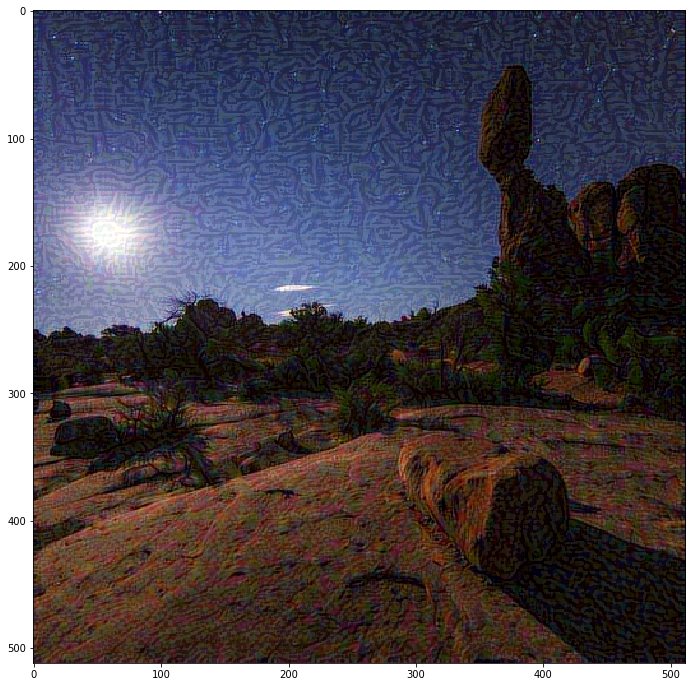

In [29]:
train_step(image)
train_step(image)
train_step(image)
plt.imshow(image.read_value()[0])

# Já que esta funcionando, vamos fazer uma otimização maior

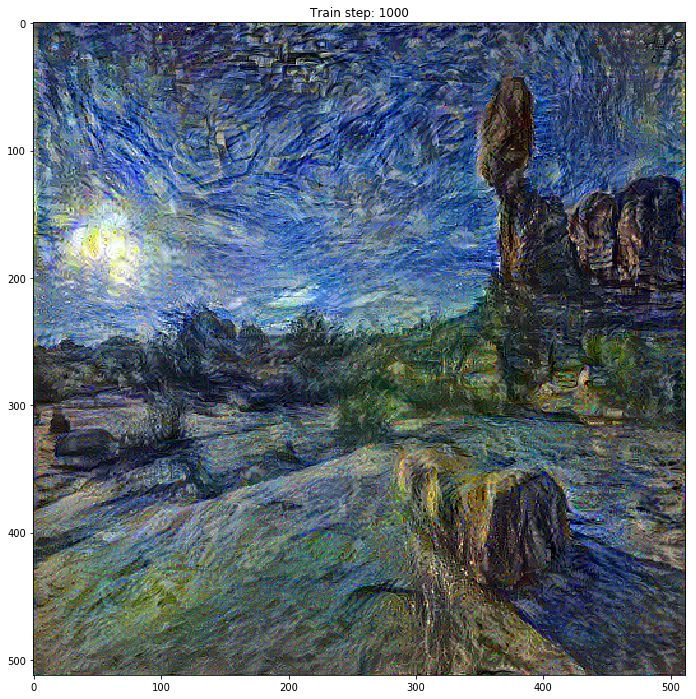

Total time: 257.7s


In [30]:
import time
start = time.time()

epochs = 10
steps_per_epoch = 100

step = 0
for n in range(epochs):
  for m in range(steps_per_epoch):
    step += 1
    train_step(image)
    print(".", end='')
  display.clear_output(wait=True)
  imshow(image.read_value())
  plt.title("Train step: {}".format(step))
  plt.show()

end = time.time()
print("Total time: {:.1f}s".format(end-start))

## Perda total de variação

Uma desvantagem dessa implementação básica é que ela produz muitos artefatos de alta frequência. Vamos Diminui-los usando um termo de regularização explícito nos componentes de alta frequência da imagem. Na transferência de estilos, isso geralmente é chamado de *perda total de variação*:


In [0]:
def high_pass_x_y(image):
  x_var = image[:,:,1:,:] - image[:,:,:-1,:]
  y_var = image[:,1:,:,:] - image[:,:-1,:,:]

  return x_var, y_var

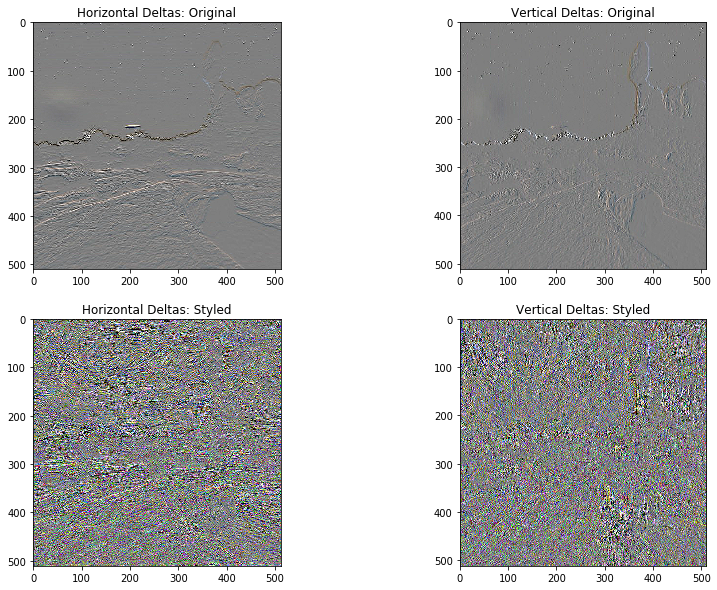

In [32]:
x_deltas, y_deltas = high_pass_x_y(content_image)

plt.figure(figsize=(14,10))
plt.subplot(2,2,1)
imshow(clip_0_1(2*y_deltas+0.5), "Horizontal Deltas: Original")

plt.subplot(2,2,2)
imshow(clip_0_1(2*x_deltas+0.5), "Vertical Deltas: Original")

x_deltas, y_deltas = high_pass_x_y(image)

plt.subplot(2,2,3)
imshow(clip_0_1(2*y_deltas+0.5), "Horizontal Deltas: Styled")

plt.subplot(2,2,4)
imshow(clip_0_1(2*x_deltas+0.5), "Vertical Deltas: Styled")

Isso mostra como os componentes de alta frequência aumentaram.

Além disso, esse componente de alta frequência é basicamente um detector de borda. Você pode obter uma saída semelhante no detector de borda Sobel, por exemplo:

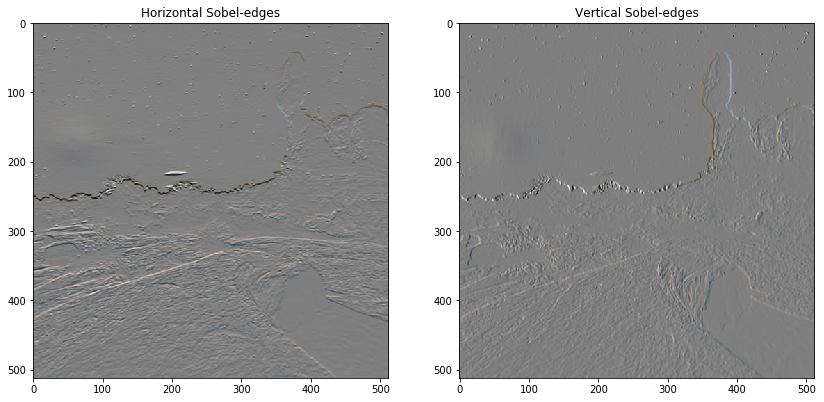

In [33]:
plt.figure(figsize=(14,10))

sobel = tf.image.sobel_edges(content_image)
plt.subplot(1,2,1)
imshow(clip_0_1(sobel[...,0]/4+0.5), "Horizontal Sobel-edges")
plt.subplot(1,2,2)
imshow(clip_0_1(sobel[...,1]/4+0.5), "Vertical Sobel-edges")

A perda de regularização associada a isso é a soma dos quadrados dos valores:

In [0]:
def total_variation_loss(image):
  x_deltas, y_deltas = high_pass_x_y(image)
  return tf.reduce_mean(x_deltas**2) + tf.reduce_mean(y_deltas**2)

## Executando novamente a otimização

Escolha um peso para o `total_variation_loss`:


In [0]:
total_variation_weight=1e8

Agora incluindo na função `train_step`:

In [0]:
@tf.function()
def train_step(image):
  with tf.GradientTape() as tape:
    outputs = extractor(image)
    loss = style_content_loss(outputs)
    loss += total_variation_weight*total_variation_loss(image)

  grad = tape.gradient(loss, image)
  opt.apply_gradients([(grad, image)])
  image.assign(clip_0_1(image))

Reinicializando a variável de otimização:


In [0]:
image = tf.Variable(content_image)

E roando a otimização:

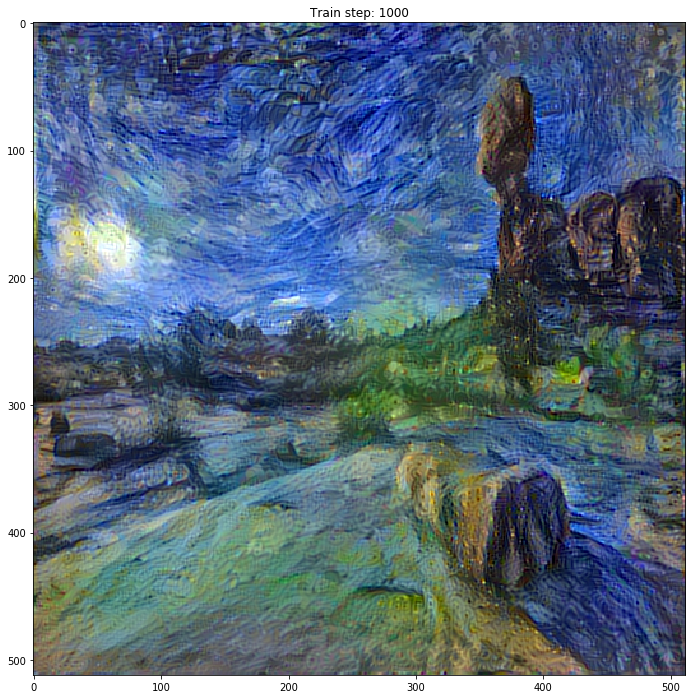

Total time: 259.2s


In [38]:
import time
start = time.time()

epochs = 10
steps_per_epoch = 100

step = 0
for n in range(epochs):
  for m in range(steps_per_epoch):
    step += 1
    train_step(image)
    print(".", end='')
  display.clear_output(wait=True)
  imshow(image.read_value())
  plt.title("Train step: {}".format(step))
  plt.show()

end = time.time()
print("Total time: {:.1f}s".format(end-start))